In [ ]:
#default_exp rurality_polygons

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [ ]:
ag_df = pd.read_csv('data/ag_df.csv',dtype=object)

In [ ]:
print(ag_df.columns)
print(len(ag_df))
print(ag_df.tail())

In [ ]:
# Select states other than HI and AK
ag_df2 = ag_df[~ag_df['State'].isin(['HI','AK'])]
print(len(ag_df2))

50091


In [ ]:
county_freqs = ag_df2['FIPS Code'].value_counts().rename_axis('FIPS Code').reset_index(name='freq')

In [ ]:
len(county_freqs)

3000

In [ ]:
county_freqs.dtypes

FIPS Code    object
freq          int64
dtype: object

In [ ]:
county_freqs.head()

,FIPS Code,freq
0,6037,441
1,6019,310
2,6107,293
3,4013,246
4,48201,238


In [ ]:
county_freqs['FIPS Code'] = county_freqs['FIPS Code'].astype(float).astype(int)

In [ ]:
def behind(code):
    if len(str(code)) == 4:
        return '0' + str(code)
    else:
        return str(code)
county_freqs['FIPS Code'] = county_freqs['FIPS Code'].apply(behind)

In [ ]:
county_freqs.drop_duplicates(inplace=True)

In [ ]:
len(county_freqs)

3000

In [ ]:
county_freqs['FIPS Code'].head()

0    06037
1    06019
2    06107
3    04013
4    48201
Name: FIPS Code, dtype: object

In [ ]:
counties = gpd.read_file('map_files/erictech/gz_2010_us_050_00_500k.shp')
print(len(counties))
print(counties.dtypes)

3221
GEO_ID         object
STATE          object
COUNTY         object
NAME           object
LSAD           object
CENSUSAREA    float64
geometry       object
dtype: object


In [ ]:
counties2 = pd.DataFrame(counties)

In [ ]:
counties.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.3887171312565 33.9130442466707, ..."
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.030441 31.618939, -86.0040849999..."
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00927999999999 33.101638, -86.00..."
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.3485063167533 30.994339155609, -..."
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.146992 31.680455, -86.147114 31...."


In [ ]:
# Select states other than HI and AK
counties2 = counties2[~counties2['STATE'].isin(['02','15'])]
print(len(counties2))

3187


In [ ]:
# Make a FIPS_Code column in the counties_geo_df geodataframe.
def combine_fips (row):
    return str(row['STATE']).strip() + str(row['COUNTY']).strip()

In [ ]:
counties2['FIPS Code'] = counties2.apply(combine_fips,axis=1)

In [ ]:
counties2['FIPS Code'].head()

0    01029
1    01031
2    01037
3    01039
4    01041
Name: FIPS Code, dtype: object

In [ ]:
counties_geo = counties2.merge(county_freqs,how='left',on='FIPS Code',indicator=True)

In [ ]:
counties_geo.columns

Index(['GEO_ID', 'STATE', 'COUNTY', 'NAME', 'LSAD', 'CENSUSAREA', 'geometry',
       'FIPS Code', 'freq', '_merge'],
      dtype='object')

In [ ]:
counties_geo['_merge'].value_counts()

both          3000
left_only      187
right_only       0
Name: _merge, dtype: int64

In [ ]:
counties_geo = counties_geo[counties_geo['_merge']!='right_only']

In [ ]:
len(counties_geo)

3187

In [ ]:
counties_geo_df = gpd.GeoDataFrame(counties_geo,crs={'init' :'epsg:4326'})
counties_geo_df2 = counties_geo_df[['freq','geometry']]

In [ ]:
print(counties_geo_df2.columns)
print(counties_geo_df2.dtypes)
print(counties_geo_df2.head())

Index(['freq', 'geometry'], dtype='object')
freq        float64
geometry     object
dtype: object
   freq                                           geometry
0   1.0  POLYGON ((-85.3887171312565 33.9130442466707, ...
1  13.0  POLYGON ((-86.030441 31.618939, -86.0040849999...
2   2.0  POLYGON ((-86.00927999999999 33.101638, -86.00...
3  14.0  POLYGON ((-86.3485063167533 30.994339155609, -...
4   2.0  POLYGON ((-86.146992 31.680455, -86.147114 31....


In [ ]:
print(len(counties_geo_df2))
counties_geo_df2 = counties_geo_df2[~counties_geo_df2['freq'].isnull()]
print(len(counties_geo_df2))

3187
3000


In [ ]:
counties_geo_df2['freq'] = counties_geo_df2['freq'].astype(int)

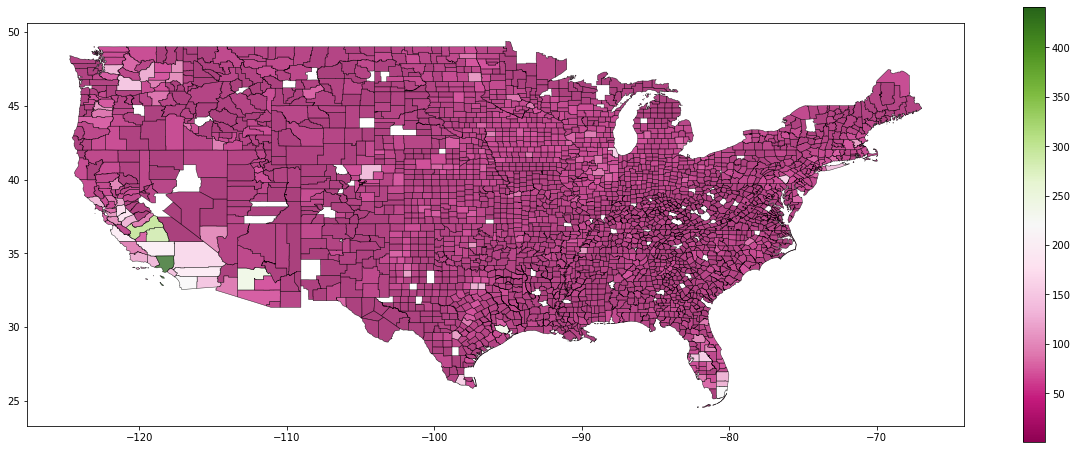

In [ ]:
# Number of ag businesses by county
fig,ax = plt.subplots(figsize=(21,8))

counties_geo_df2.plot(column='freq',ax=ax,alpha=0.75,lw=0.5,edgecolor='black',cmap='PiYG',legend=True) 

In [ ]:
# This obviously needs a pattern of bins with more detail at the low end instead of relying on the default linear
# scale of the built-in color maps.